In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

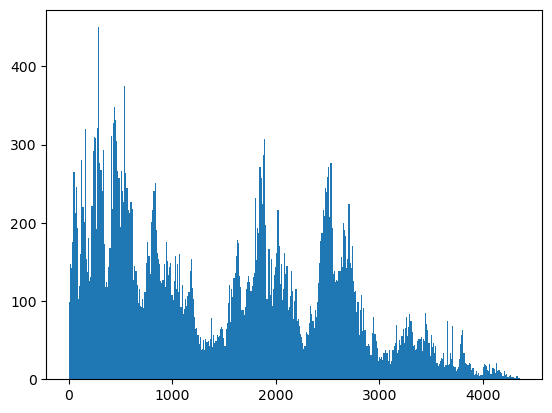

In [2]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd

df = pd.read_csv('D:/data/Zircons/Roberts_Spencer_2015.csv')
ages = df["U-Pb (Ma)"]
data = plt.hist(ages, bins = 400)

In [3]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


In [4]:
zircons_data = data[0]
ages = data[1][1:]

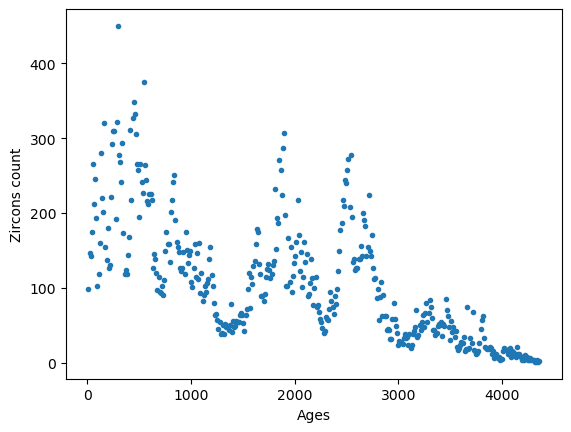

In [5]:
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [6]:
ages_nominal = np.arange(len(ages))

In [7]:
with pm.Model() as zircons_model:
    
    k = 2
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    
    switchpoint = pm.DiscreteUniform("switchpoint", lower=ages_nominal.min(), upper=ages_nominal.max(),shape= k)
    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    #注意，这里的问题是，虽然我们可以通过排序的方式使得两个分布具有大小关系，但是统计模型给出的后验分布是排序之前的
    #这里有两种解决方案，其一是直接生成有顺序的拐点
    #其二是找到switchpoint1和switchpoint2并列出他们的后验分布
    newswitchpoint = pm.math.switch(switchpoint[0]>switchpoint[1],(switchpoint[1],switchpoint[0]),(switchpoint[0],switchpoint[1])) 
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)
    rates = pm.Exponential("rates",1.0,shape = k+1)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
    
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [8]:
with zircons_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [rates]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


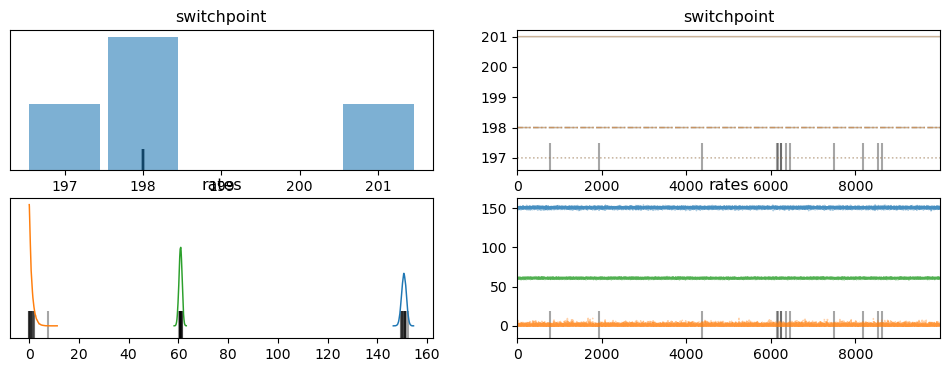

In [9]:
az.plot_trace(idata, combined=True);

In [10]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint[0],198.50,1.50,197.00,201.00,0.75,0.57,4.00,4.00,5.556107e+15
switchpoint[1],198.50,1.50,197.00,201.00,0.75,0.57,4.00,4.00,5.556107e+15
rates[0],150.69,0.95,148.92,152.49,0.20,0.14,23.09,72.94,1.110000e+00
rates[1],0.99,0.99,0.00,2.81,0.01,0.00,24986.87,15268.73,1.000000e+00
rates[2],60.84,0.62,59.63,61.97,0.15,0.11,16.92,57.47,1.150000e+00


In [11]:
with pm.Model() as zircons_model:
    
    k = 2
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    
    switchpoint1 = pm.DiscreteUniform("switchpoint1", lower=ages_nominal.min(), upper=ages_nominal.max()-1)
    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    switchpoint2 = pm.DiscreteUniform("switchpoint2", lower=switchpoint1+1, upper=ages_nominal.max())
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)
    rates = pm.Exponential("rates",1.0,shape = k+1)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
        
    if pm.math.lt(ages_nominal,switchpoint1):
        rate = rates[0]
    else:
        if pm.math.gt(ages_nominal,switchpoint2):
            rate = rates[2]
        else:
            rate = rates[1]
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [12]:
with zircons_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint1]
>>Metropolis: [switchpoint2]
>NUTS: [rates]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 26 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


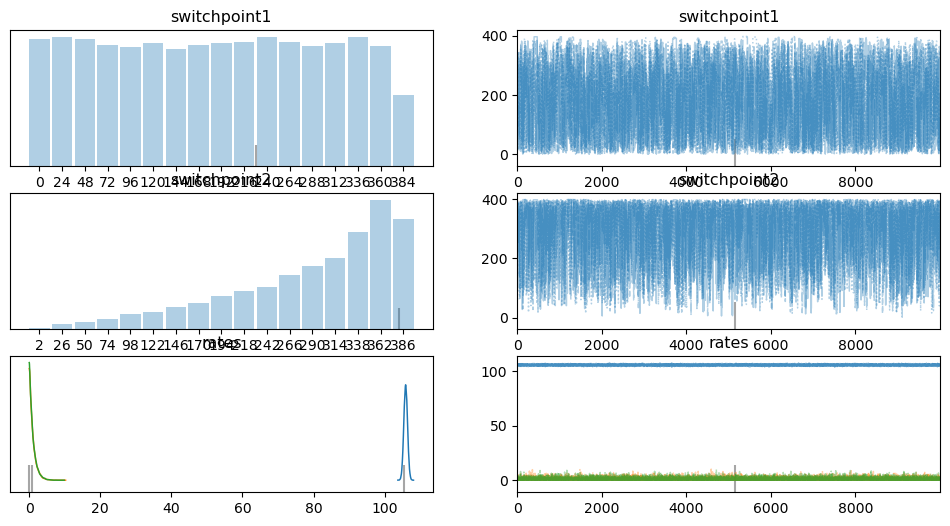

In [13]:
az.plot_trace(idata, combined=True);

In [14]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint1,198.10,115.46,5.00,377.00,2.80,2.15,1488.54,1152.82,1.0
switchpoint2,299.98,88.15,129.00,399.00,1.74,1.29,1864.05,1119.40,1.0
rates[0],105.91,0.52,104.93,106.87,0.00,0.00,28721.48,26892.17,1.0
rates[1],1.00,0.99,0.00,2.81,0.01,0.00,20843.10,13747.42,1.0
rates[2],1.00,1.00,0.00,2.82,0.01,0.00,21788.74,15374.89,1.0


In [15]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

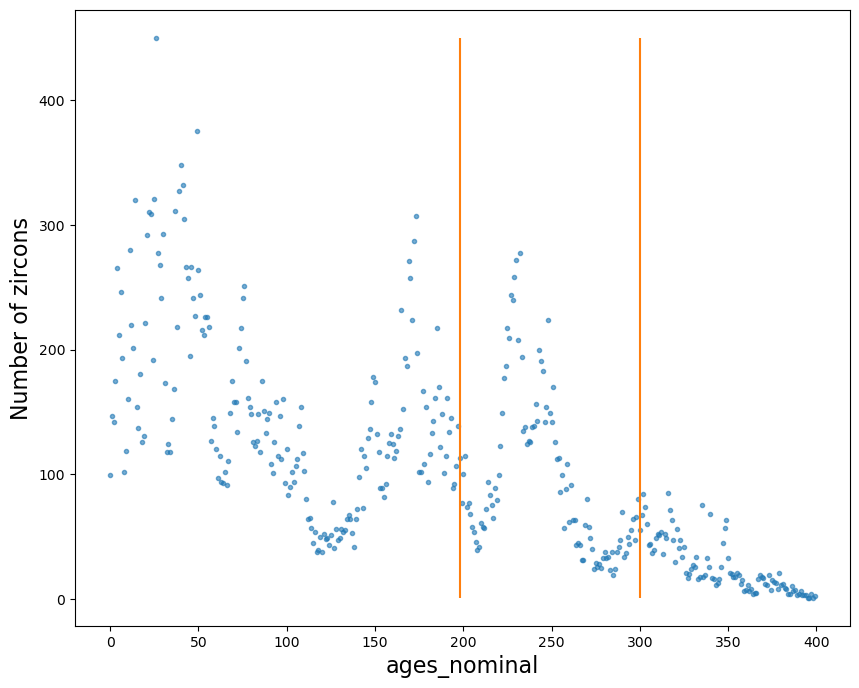

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(ages_nominal, zircons_data, ".", alpha=0.6)
plt.ylabel("Number of zircons", fontsize=16)
plt.xlabel("ages_nominal", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint1"].mean(), zircons_data.min(), zircons_data.max(), color="C1")
plt.vlines(trace["switchpoint2"].mean(), zircons_data.min(), zircons_data.max(), color="C1")

In [24]:
with pm.Model() as zircons_model:
    
    k = 2
    # Priors for numbers of switch point
    #k = pm.DiscreteUniform("k",lower = 1, upper = max)
    # Priors for switch point
    
    switchpoint1 = pm.DiscreteUniform("switchpoint1", lower=ages_nominal.min(), upper=ages_nominal.max()-1)
    #lowers = pm.math.constant(ages_nominal.min(),ndim = k)
    #uppers = pm.math.constant(ages_nominal.max(),ndim = k)
    #switchpoint = pm.DiscreteUniform("switchpoint", lower=lowers, upper=uppers)
    switchpoint2 = pm.DiscreteUniform("switchpoint2", lower=switchpoint1+1, upper=ages_nominal.max())
    newswitchpoint = [switchpoint1,switchpoint2]
    
    # Priors for pre- and post-switch rates number of disasters
    #early_rate = pm.Exponential("early_rate", 1.0)
    #late_rate = pm.Exponential("late_rate", 1.0)
    rates = pm.Exponential("rates",1.0,shape = k+1)

    # Allocate appropriate Poisson rates to years before and after current
    #rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)
    #index = 0
    #for i in range(k):
        #index += pm.math.switch(switchpoint >= rates[i], 1, 0)
    #rate = rates[index]
    #rate = rates[0]
    #for i in range(k):
        #rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
    rate = rates[0]
    for i in range(k):
        rate = pm.math.switch(newswitchpoint[i] >= ages_nominal, rate, rates[i+1])
    
    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [28]:
with zircons_model:
    idata = pm.sample(30000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint1]
>>Metropolis: [switchpoint2]
>NUTS: [rates]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 45 seconds.
E:\anaconda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


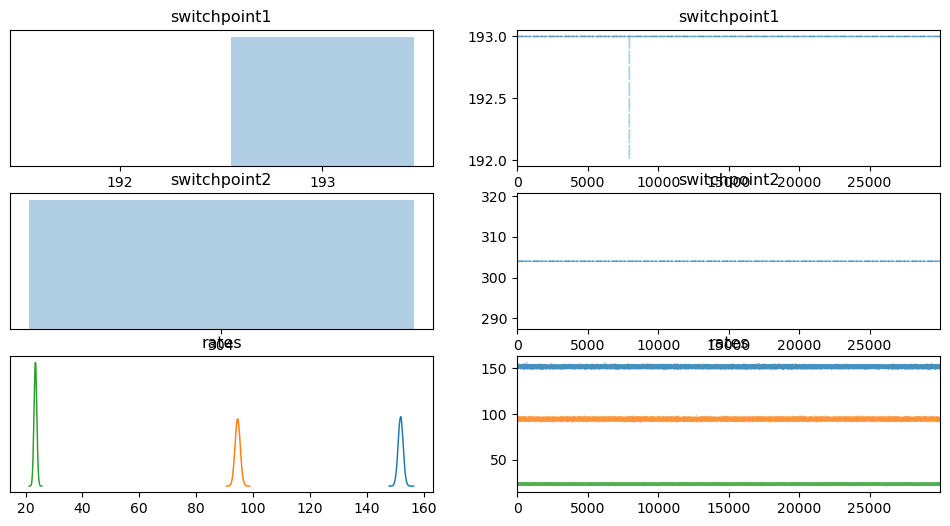

In [29]:
az.plot_trace(idata, combined=True);

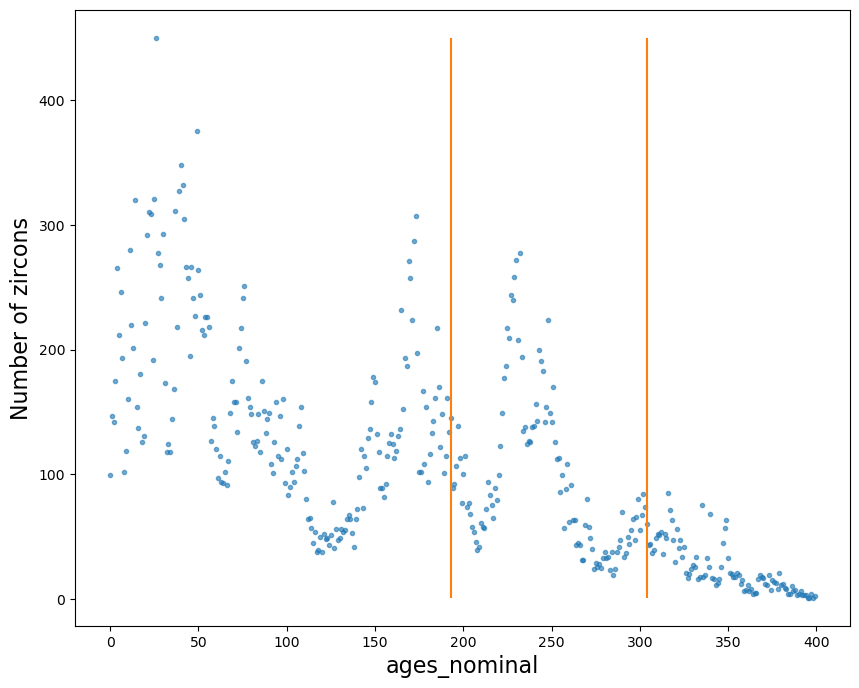

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(ages_nominal, zircons_data, ".", alpha=0.6)
plt.ylabel("Number of zircons", fontsize=16)
plt.xlabel("ages_nominal", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint1"].mean(), zircons_data.min(), zircons_data.max(), color="C1")
plt.vlines(trace["switchpoint2"].mean(), zircons_data.min(), zircons_data.max(), color="C1")